In [48]:
# Define autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
# Adopted from Andrew's project

from training_defs import load_spectral_data, get_dataloaders
from model import MLP
import torch, torch.nn as nn, torch.optim as optim
import matplotlib.pyplot as plt

X, y = load_spectral_data()
train_loader, val_loader = get_dataloaders(X, y)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(in_dim=X.shape[1], h_dim=128, out_dim=3).to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 100
loss_mult = 2
train_losses, val_losses = [], []

In [51]:
for epoch in range(1, n_epochs+1):
    model.train()
    tot_train = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb) * loss_mult
        loss.backward()
        optimizer.step()
        tot_train += loss.item() * xb.size(0)
    train_losses.append(tot_train / len(train_loader.dataset))

    model.eval()
    tot_val = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            tot_val += criterion(model(xb), yb).item() * xb.size(0)
    val_losses.append(tot_val / len(val_loader.dataset))

    print(f"epoch {epoch:02d}  train loss: {train_losses[-1]:.4f}  val loss: {val_losses[-1]:.4f}")

epoch 01  train loss: 23.8507  val loss: 0.1841
epoch 02  train loss: 17.5737  val loss: 0.1670
epoch 03  train loss: 15.9667  val loss: 0.1567
epoch 04  train loss: 15.2756  val loss: 0.1555
epoch 05  train loss: 15.3937  val loss: 0.1474
epoch 06  train loss: 14.0323  val loss: 0.1460
epoch 07  train loss: 14.5500  val loss: 0.1507
epoch 08  train loss: 13.3988  val loss: 0.1393
epoch 09  train loss: 12.7869  val loss: 0.1233
epoch 10  train loss: 12.0280  val loss: 0.1224
epoch 11  train loss: 12.0202  val loss: 0.1293
epoch 12  train loss: 11.1485  val loss: 0.0999
epoch 13  train loss: 10.7072  val loss: 0.1097
epoch 14  train loss: 9.8787  val loss: 0.1017
epoch 15  train loss: 9.3764  val loss: 0.0967
epoch 16  train loss: 8.9740  val loss: 0.1243
epoch 17  train loss: 10.7022  val loss: 0.0902
epoch 18  train loss: 9.3301  val loss: 0.0962
epoch 19  train loss: 9.0271  val loss: 0.1003
epoch 20  train loss: 8.7414  val loss: 0.0826
epoch 21  train loss: 8.2653  val loss: 0.0827

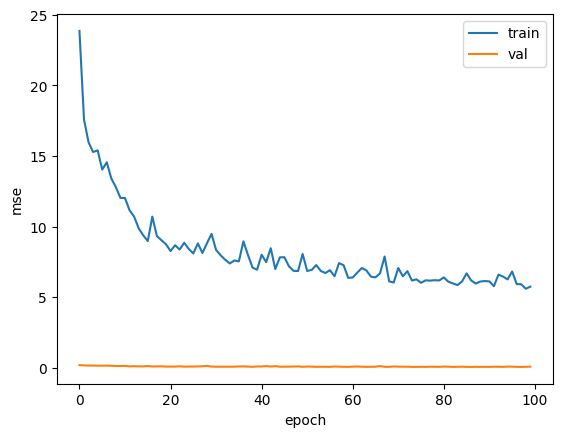

In [52]:
plt.plot(train_losses, label="train")
plt.plot(val_losses,   label="val")
plt.xlabel("epoch"); plt.ylabel("mse"); plt.legend(); plt.show()

torch.save(model.state_dict(), "spectra_mlp.pth")

In [53]:
import numpy as np
from sklearn.metrics import r2_score, root_mean_squared_error

model.eval()

all_preds, all_targets = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(yb.cpu().numpy())

all_preds = np.vstack(all_preds)
all_targets = np.vstack(all_targets)

r2 = r2_score(all_targets, all_preds, multioutput="uniform_average")
rmse = root_mean_squared_error(all_targets, all_preds)

print(f"validation r^2:  {r2:.4f}")
print(f"validation rmse: {rmse:.4f}")

validation r^2:  0.8400
validation rmse: 0.1201
